In [1]:
import pandas as pd
from random import seed, randrange
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from sklearn.metrics import fbeta_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
# we need to remove some stopwords form the nltk library stopwords so that we can classify the negative and postive reviews properly
# so we will be making our own customized stopwords

In [3]:
stopwords = ['from', "she's", 'theirs', 'be', 'won', 'shouldn', 'should', 'or', 'were', 'she', "shouldn't", 'until', 'himself', 'd', 'at', 'than', 'aren', "doesn't", 've', 'o', 'mustn', "you've", 'ours', 'wasn', 'but', 'once', 'there', "didn't", 'we', 'has', 'am', 'of', 'own', "you'd", 'in', 'he', "shan't", "mightn't", "don't", 'having', 'with', 'my', 'its', 'had', 'y', 'yourselves', 'didn', 'your', 'each', "haven't", 'yourself', 'and', 'is', 'nor', 'who', 'whom', 'couldn', 'this', 'mightn', 'shan', 'have', 'for', 'her', 'hers', 'other', 'during', 'herself', 'themselves', 'here', 'them', 's', 'hadn', "it's", 'so', "mustn't", 'did', 'about', 'after', "hadn't", 'haven', "you'll", 'can', 'just', 'isn', 'the', 'our', 'by', 'further', 'do', 'on', 're', 'doing', "aren't", 'off', 'some', 'an', 'only', 'over', 'me', 'while', 'will', 'too', 'i', 'under', 'more', "you're", 'their', 'you', 'as', 'ourselves', 'both', 'where', 'then', "hasn't", "weren't", "won't", 'before', 'are', "wouldn't", 'needn', 'because', 'doesn', 'into', 'that', 'between', "wasn't", 'it', 'him', 'up', 'above', 'his', 'these', 'm', 'been', "couldn't", 'to', 'those', 'same', 'don', 'out', 'ma', 'below', 'being', 'such', 'what', 'wouldn', "that'll", 'itself', 'hasn', "isn't", 'again', 'through', 'very', 'll', 'which', 'when', "should've", 'any', 't', 'how', 'all', "needn't", 'yours', 'weren', 'myself', 'a', 'they', 'if', 'ain', 'does', 'was', 'now', 'most', 'why']

In [4]:
dataset = pd.read_csv(r"C:/Users/shekh/Desktop/NLP Sentiment Analysis/amazon.txt",
                 delimiter="\t",header=None,names=["review","sentiment"])

In [5]:
dataset.shape

(1000, 2)

In [6]:
dataset.head()

,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


## 1: good review,   0: bad review

In [7]:
lemmatizer = WordNetLemmatizer()

In [8]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
cr = []
for i in range(0,len(dataset)):
    cr.append(decontracted(dataset['review'][i]))

In [10]:
dataset['review1'] = pd.DataFrame(cr)

In [11]:
corpus = []
for i in range(0, len(dataset)):
    review = re.sub('[^a-zA-Z]', ' ', dataset['review1'][i])
    review = review.lower()
    review = review.split()
    
    review = [lemmatizer.lemmatize(word) for word in review if not word in stopwords]
    review = ' '.join(review)
    corpus.append(review)

In [12]:
type(corpus)

list

In [13]:
X = pd.DataFrame(corpus,columns=['review'])
y = dataset[['sentiment']]

In [14]:
X.shape

(1000, 1)

In [15]:
tfidf = TfidfVectorizer(ngram_range=(1,3))

In [16]:
X = tfidf.fit_transform(X['review']).toarray()

In [17]:
y = y.to_numpy()

### Train test Split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=40,stratify=y)

### Now lets build and run ML models

### Random Forest

In [20]:
# Random Forest Classifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state= 42)  

scoring = {"Recall": 'recall', "Accuracy": 'accuracy'}

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1)
parameter = {
             'n_estimators': [100,200],
             'max_depth' : [4,5,6],
             'criterion' :['gini', 'entropy'],
             'min_samples_leaf': [3, 4, 5],
             'min_samples_split': [8, 10, 12],
             'bootstrap': [True, False] # boot straping method is used to build the tree rather than using whole dataset

            }

result_rf = GridSearchCV(estimator = model_rf, 
                         param_grid = parameter, 
                         cv = cv, 
                         scoring= scoring,
                         refit="Recall", #refits with the parameter setting that has the best cross-validated score.
                         n_jobs = -1, #means using all processors
                         return_train_score =False # to get insights on how different parameter settings impact the overfitting/underfitting trade-off.
                        )

result_rf.fit(X_train, y_train)
print(result_rf.best_params_)
print(result_rf.best_score_)


{'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 200}
0.72


In [21]:
y_pred_rf = result_rf.predict(X_test)

In [22]:
score=accuracy_score(y_test,y_pred_rf)
print(score)
report=classification_report(y_test,y_pred_rf)
print(report)

0.7933333333333333
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       150
           1       0.92      0.64      0.76       150

    accuracy                           0.79       300
   macro avg       0.82      0.79      0.79       300
weighted avg       0.82      0.79      0.79       300



In [23]:
score=accuracy_score(y_test,y_pred_rf)
print(score)
report=classification_report(y_test,y_pred_rf)
print(report)

0.7933333333333333
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       150
           1       0.92      0.64      0.76       150

    accuracy                           0.79       300
   macro avg       0.82      0.79      0.79       300
weighted avg       0.82      0.79      0.79       300



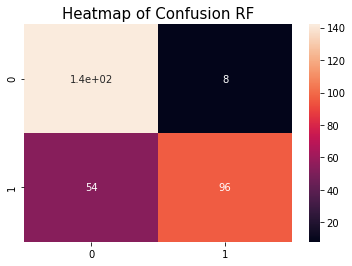

In [24]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.title('Heatmap of Confusion RF', fontsize = 15)
sns.heatmap(cm_rf, annot = True)
plt.show()

In [25]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True negative = ', cm[0][0])
    print('False negative = ', cm[1][0])
    print('False positive = ', cm[0][1])
    print('True positive = ', cm[1][1])

In [26]:
print_confusion_matrix(y_test, y_pred_rf)

True negative =  142
False negative =  54
False positive =  8
True positive =  96


In [27]:
fb_rf = fbeta_score(y_test, y_pred_rf, beta=1)
fb_rf

0.7559055118110237

### SVM

Support Vector Machines with a linear kernel.

In [28]:
from sklearn.svm import SVC

In [29]:

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = SVC(kernel='linear',probability=True,C=c)
    
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, svm.predict(X_test))))

Accuracy for C=0.01: 0.6633333333333333
Accuracy for C=0.05: 0.6633333333333333
Accuracy for C=0.25: 0.7533333333333333
Accuracy for C=0.5: 0.81
Accuracy for C=1: 0.8366666666666667


In [30]:
svm = SVC(C=1)

In [31]:
svm.fit(X_train, y_train)

SVC(C=1)

In [32]:
y_pred_sv = svm.predict(X_test)

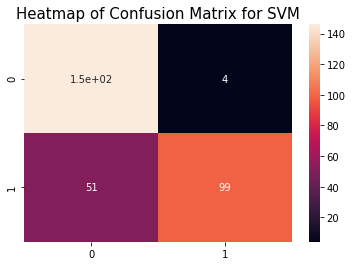

In [33]:
cm_sv = confusion_matrix(y_test, y_pred_sv)
plt.title('Heatmap of Confusion Matrix for SVM', fontsize = 15)
sns.heatmap(cm_sv, annot = True)
plt.show()

In [34]:
print_confusion_matrix(y_test, y_pred_sv)

True negative =  146
False negative =  51
False positive =  4
True positive =  99


In [35]:
fb_sv = fbeta_score(y_test, y_pred_sv, beta=1)
fb_sv

0.782608695652174

### NaiveBayes Classifier

In [36]:
# train a Gaussian Naive Bayes classifier on the training set
from sklearn.naive_bayes import GaussianNB


In [37]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [38]:
y_pred_nb = gnb.predict(X_test)

In [39]:
accuracy_score(y_test,y_pred_nb)

0.7466666666666667

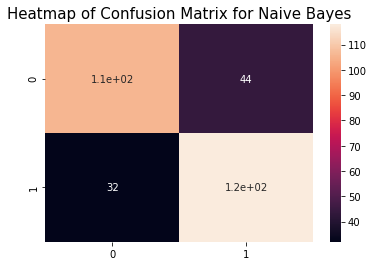

In [40]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.title('Heatmap of Confusion Matrix for Naive Bayes', fontsize = 15)
sns.heatmap(cm_nb, annot = True)
plt.show()

In [41]:
print_confusion_matrix(y_test, y_pred_nb)

True negative =  106
False negative =  32
False positive =  44
True positive =  118


In [42]:
fb_nb = fbeta_score(y_test, y_pred_nb, beta=1)
fb_nb

0.7564102564102564

## Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, lr.predict(X_test))))
    

    
# final_wc = LogisticRegression(C=0.05)
# final_wc.fit(X, target)
# print ("Final Accuracy: %s" 
#        % accuracy_score(target, final_wc.predict(X_test)))



Accuracy for C=0.01: 0.82
Accuracy for C=0.05: 0.8233333333333334
Accuracy for C=0.25: 0.8266666666666667
Accuracy for C=0.5: 0.8333333333333334
Accuracy for C=1: 0.8366666666666667


In [45]:
lr = LogisticRegression(C=1)

In [46]:
lr.fit(X_train,y_train)

LogisticRegression(C=1)

In [47]:
y_pred_lr = lr.predict(X_test)

In [48]:
accuracy_score(y_test,y_pred_lr)

0.8366666666666667

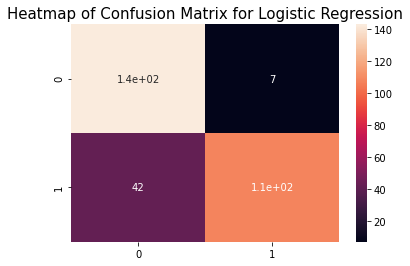

In [49]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.title('Heatmap of Confusion Matrix for Logistic Regression', fontsize = 15)
sns.heatmap(cm_lr, annot = True)
plt.show()

In [50]:
print_confusion_matrix(y_test, y_pred_lr)

True negative =  143
False negative =  42
False positive =  7
True positive =  108


In [51]:
fb_lr = fbeta_score(y_test, y_pred_lr, beta=1)
fb_lr

0.8150943396226416

## Final Result

In [52]:
list = [fb_lr,fb_rf,fb_sv,fb_nb]


if (fb_sv == max(list)):
    print('The best F1 score is {:.7f} for SupportVector Machine model.'.format(fb_sv))
elif (fb_lr == max(list)):
    print('The best F1 score is {:.7f} for Logistic Regreesion model.'.format(fb_lr))
elif (fb_nb == max(list)):
    print('The best F1 score is {:.7f} for NaiveBayes Regreesion model.'.format(fb_nb))
else: 
    print('The best F1 score is {:.7f} for Random Forest model.'.format(fb_rf))

The best F1 score is 0.8150943 for Logistic Regreesion model.


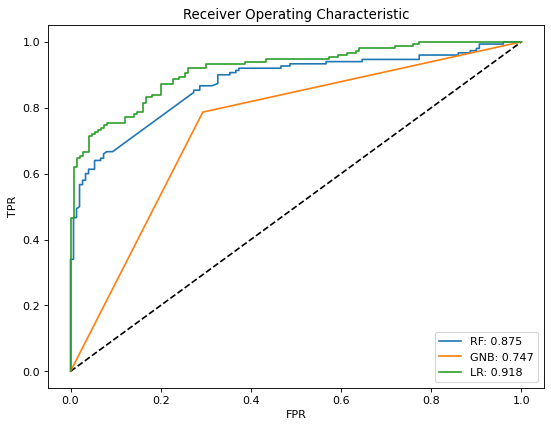

In [53]:
#ROC Curve
from matplotlib.pyplot import figure
import sklearn.metrics as metrics

figure(figsize=(8, 6), dpi=80)
from sklearn.metrics import roc_curve
y_pred_prob1 = result_rf.predict_proba(X_test)[:,1]

fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)
auc = round(metrics.roc_auc_score(y_test, y_pred_prob1),3)

# y_pred_prob2 = svm.predict_proba(X_test)[:,1]
# fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)


y_pred_prob3 = gnb.predict_proba(X_test)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_pred_prob3)
auc3 = round(metrics.roc_auc_score(y_test, y_pred_prob3),3)
y_pred_prob4 = lr.predict_proba(X_test)[:,1]
fpr4 , tpr4, thresholds4 = roc_curve(y_test, y_pred_prob4)
auc4 = round(metrics.roc_auc_score(y_test, y_pred_prob4),3)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "RF: "+str(auc))
# plt.plot(fpr2, tpr2, label= "SVM")
plt.plot(fpr3, tpr3, label= "GNB: "+str(auc3))
plt.plot(fpr4, tpr4, label= "LR: "+str(auc4))
plt.legend(loc=4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()